### Δεδομένα

Data Link: https://www.cryptodatadownload.com/data/binance/ 

Τα δεδομένα που χρησιμοποιούμε είναι από την πλατφόρμα της binance.

### Λίγες πληρφορίες για αυτά:

Περιέχουν τις πληροφορίες του bitcoin ανά λεπτό.


Επίσης η πληροφορία που μας ενδιαφέρει είναι το close του BTC. Το close είναι η τιμή που διαμορφόθηκε εκείνη τη στιγμή στο bitcoin. Το volume είναι η ποσότητα που αγοράστηκε/πουλήθηκε εκείνη τι στιγμή. 

'Αρα στην ουσία το close είναι η τιμή ενός BTC που συναλλάχθηκε εκέίνη τη στιγμή και το volume είναι η ποσότητα που συναλλάχθηκε.

Το open είναι η τιμή που άνοιξε στο bitcoin, το low είναι η χαμηλότερη τιμή πώλησης του ανοίγματος και το high η ηψυλότερη τιμή

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.preprocessing import MinMaxScaler
import random
import time
import copy
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import tensorflow as tf
%matplotlib inline

## Import data

In [2]:
btc_input_df  = pd.read_csv("BTC-USD.csv", parse_dates=["time"], nrows=14400)
btc_input_df.head()

,time,low,high,open,close,volume
0,2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079
1,2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357
2,2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848
3,2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070
4,2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128


In [3]:
btc_input_df = btc_input_df.set_index('time')
btc_input_df.head()

,low,high,open,close,volume
time,,,,,
2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079
2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357
2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848
2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070
2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128


In [4]:
btc_input_df = btc_input_df.sort_index()
btc_input_df.head()

,low,high,open,close,volume
time,,,,,
2021-10-20 03:01:00,63816.52,63860.23,63839.44,63823.36,2.736049
2021-10-20 03:02:00,63812.47,63835.33,63823.36,63827.88,3.145124
2021-10-20 03:03:00,63810.00,63837.24,63827.56,63810.01,6.178755
2021-10-20 03:04:00,63792.27,63823.50,63810.00,63817.06,4.367886
2021-10-20 03:05:00,63806.39,63849.85,63813.21,63847.04,6.441521


In [5]:
print(btc_input_df.shape)
print("------------------------")
print(btc_input_df.info())

(14400, 5)
------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14400 entries, 2021-10-20 03:01:00 to 2021-10-30 03:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   low     14400 non-null  float64
 1   high    14400 non-null  float64
 2   open    14400 non-null  float64
 3   close   14400 non-null  float64
 4   volume  14400 non-null  float64
dtypes: float64(5)
memory usage: 675.0 KB
None


In [6]:
btc_input_df.head()

,low,high,open,close,volume
time,,,,,
2021-10-20 03:01:00,63816.52,63860.23,63839.44,63823.36,2.736049
2021-10-20 03:02:00,63812.47,63835.33,63823.36,63827.88,3.145124
2021-10-20 03:03:00,63810.00,63837.24,63827.56,63810.01,6.178755
2021-10-20 03:04:00,63792.27,63823.50,63810.00,63817.06,4.367886
2021-10-20 03:05:00,63806.39,63849.85,63813.21,63847.04,6.441521


In [7]:
btc_input_df.tail()

,low,high,open,close,volume
time,,,,,
2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128
2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070
2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848
2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357
2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079


## Plot informations

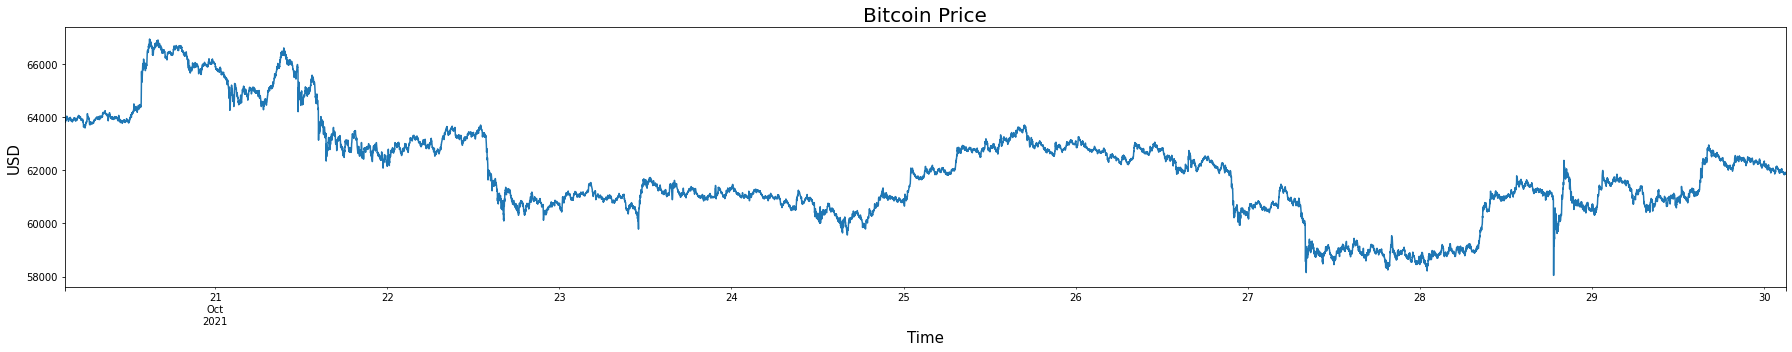

In [8]:
plt.figure(figsize=(20,5))
plt.title("Bitcoin Price", fontsize=20)
btc_input_df.close.plot(figsize=(25,5))
plt.xlabel("Time", fontsize=15)
plt.ylabel("USD", fontsize=15)
plt.tight_layout()

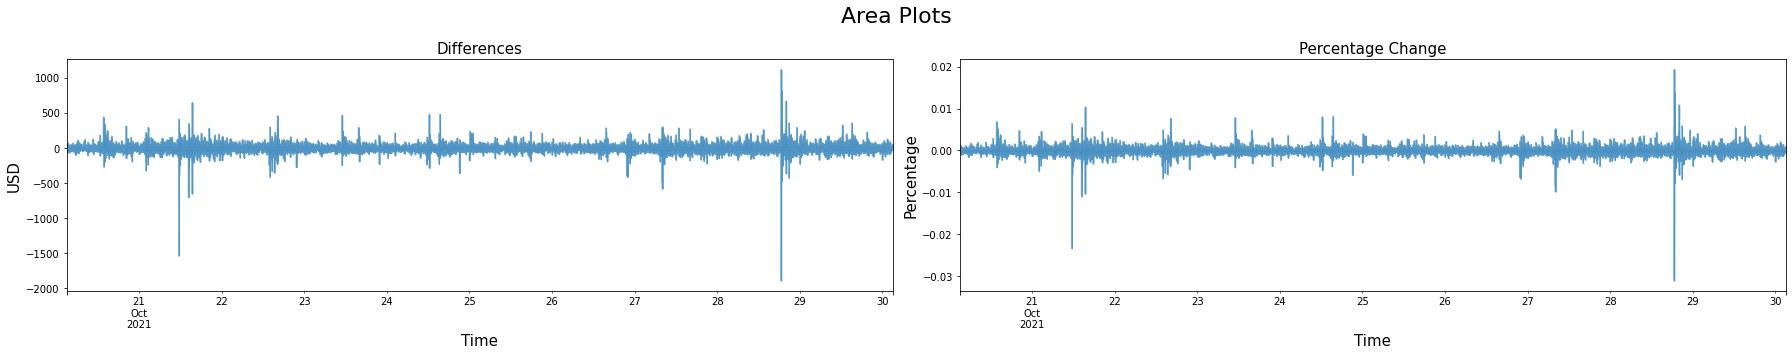

In [9]:
plt.figure(figsize=(25,5))
plt.suptitle('Area Plots', fontsize=22)

plt.subplot(1,2,1)
btc_input_df.close.diff().plot.area(stacked=False,)
plt.ylabel("USD", fontsize="15")
plt.xlabel("Time", fontsize="15")
plt.title("Differences", fontsize="15")

plt.subplot(1,2,2)
btc_input_df.close.pct_change().plot.area(stacked=False, )
plt.ylabel("Percentage", fontsize="15")
plt.xlabel("Time", fontsize="15")
plt.title("Percentage Change", fontsize="15")

plt.tight_layout()

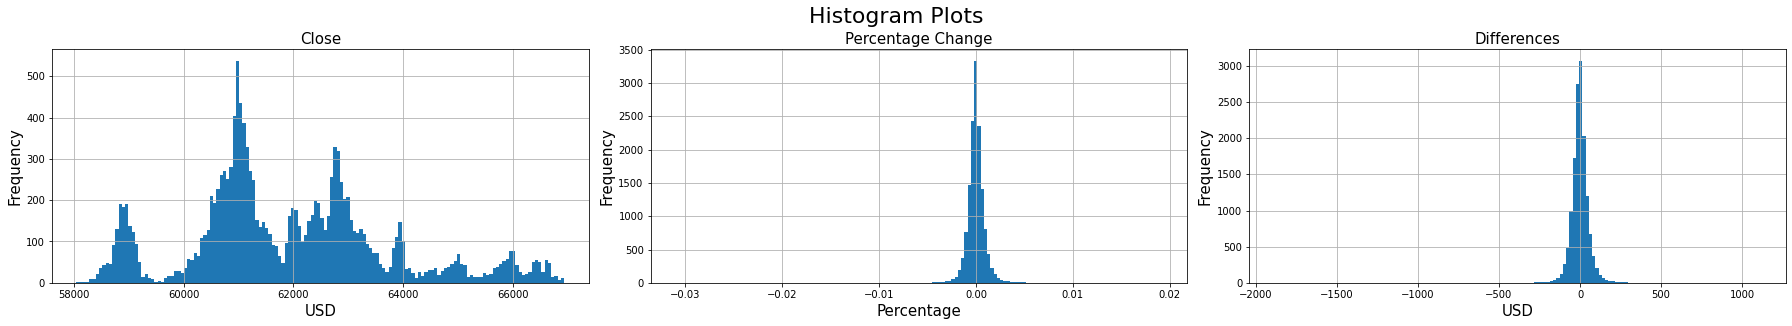

In [10]:
plt.figure(figsize=(25,12))
plt.suptitle('Histogram Plots', fontsize=22)

plt.subplot(3,3,1)
btc_input_df.close.hist(bins=150)
plt.xlabel("USD", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title('Close', fontsize=15)

plt.subplot(3,3,2)
btc_input_df.close.pct_change().hist(bins=150)
plt.xlabel("Percentage", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title('Percentage Change', fontsize=15)

plt.subplot(3,3,3)
btc_input_df.close.diff().hist(bins=150)
plt.xlabel("USD", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title('Differences', fontsize=15)

plt.tight_layout()

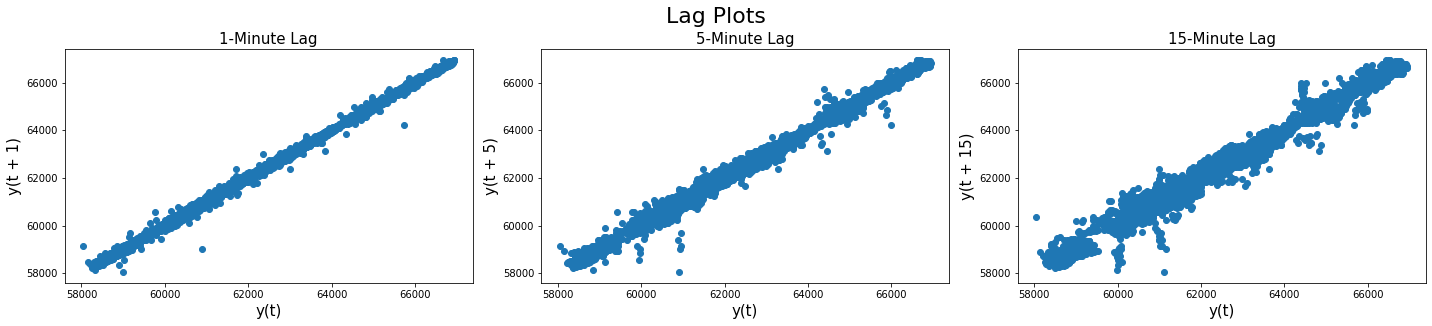

In [11]:
# κάνουμε plot το corelation 
plt.figure(figsize=(20,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(btc_input_df['close'], lag=1) #minute lag
plt.xlabel("y(t)", fontsize=15)
plt.ylabel("y(t + 1)", fontsize=15)
plt.title('1-Minute Lag', fontsize=15)

plt.subplot(3,3,2)
pd.plotting.lag_plot(btc_input_df['close'], lag=5) 
plt.xlabel("y(t)", fontsize=15)
plt.ylabel("y(t + 5)", fontsize=15)
plt.title('5-Minute Lag', fontsize=15)

plt.subplot(3,3,3)
pd.plotting.lag_plot(btc_input_df['close'], lag=15) 
plt.xlabel("y(t)", fontsize=15)
plt.ylabel("y(t + 15)", fontsize=15)
plt.title('15-Minute Lag', fontsize=15)

plt.tight_layout()

## Pre processing data for LSTM model

In [12]:
btc_closing_price = btc_input_df['close'].copy()
btc_closing_price.head()

time
2021-10-20 03:01:00    63823.36
2021-10-20 03:02:00    63827.88
2021-10-20 03:03:00    63810.01
2021-10-20 03:04:00    63817.06
2021-10-20 03:05:00    63847.04
Name: close, dtype: float64

In [13]:
df_train= btc_closing_price[:-2000].copy()
df_test= btc_closing_price[-2000:].copy()

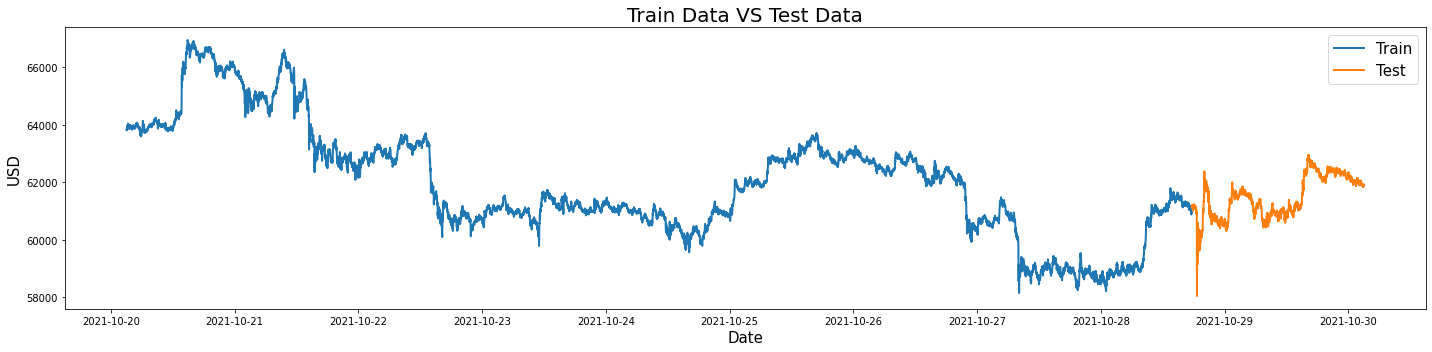

In [14]:
plt.figure(figsize=(20,5))
plt.plot(df_train, label='Train', linewidth=2, )
plt.plot(df_test, label='Test', linewidth=2)
plt.xlabel("Date", fontsize=15)
plt.ylabel('USD', fontsize=15)
plt.title('Train Data VS Test Data', fontsize=20)
plt.legend(loc='best', fontsize=15)
plt.tight_layout()

In [15]:
df_train= df_train.values.reshape(df_train.shape[0],1)
df_test= df_test.values.reshape(df_test.shape[0],1)

In [16]:
df_train.shape

(12400, 1)

In [17]:
"""
Ο λόγος που χωρίζουμε πρώτα τα δεδομένα μας και μετά τα κανονικοποιούμε
είναι διότι αν κάναμε το αντίθετο, όταν θα γινόταν το scaling, θα χρησιμοποιούνταν
(ως σημείο αναφοράς) τα δεδομένα που έχουμε ως training και αυτό θα επηρέαζε τα δεδομένα εκαπίδευσης.
Στην ουσία θα είχαμ "διαρροή" των αποτελεσμάτων του training set
"""
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [18]:
"""
Θα δημιουργήσουμε μια συνάρτηση που θα χωρίζει το datest σε input που θα δέχεται
το μοντέλο και τα label που πρέπει να προβλέπει.

Για παράδειγμα αν τα δεδομένα μας είχαν την μορφή [1, 2, 3, 4, 5, 6]
τότε τα input που θα παίρνει το μοντέλο μας και το αντίστοιχο output , θα ήταν κάπως έτσι:

Input | Output
1, 2      3
2, 3      4
3, 4      5
4, 5      6


Τα LSTMs δέχονται σαν είσοδο δεδομένα 2 διαστάσεων.
Η πρώτη διάσταση είναι ο αριθμός των χρονικών βημάτων, στο παράδειγμα μας είναι 2,
και η δεύτερη διάσταση είναι ο αριθμός των παρατηρήσεων ανά χρονικό βήμα, στο παράδειγμα είναι 1

"""
def dataset_generator_lstm(dataset, look_back=10):
    """
    Συνάρτηση που επιστρέφει όσα περιγράψαμε παραπάνω. Η παράμετρος
    look back προσδιορίζει πόσα προηγούμενα timesteps θα λάβουμε υπόψη
    για να προβλέψουμε το επόμενο timestep.
    Για παράδειγμα αν θέλουμε να προβλέψουμε τι θα γίνει την χρονική στιγμή t+1 (όπου t είναι η τωρινη
    χρονική στιγμή.) με look back ίσο με 10 , τότε θα χρησιμοποιουθούν τα δεδομένα της χρονική στιγμής
    t-9 , t-8, ... , t-1, t-0
    """    
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):   
        window_size_x = dataset[i:(i + look_back)]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back])
        
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)
testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testΧ: ", testX.shape)
print("testY", testY.shape)

trainX:  (12390, 10, 1)
trainY:  (12390, 1)
testΧ:  (1990, 10, 1)
testY (1990, 1)


Για το LSTM πρέπει να αναδιαμορφώσoyme την είσοδο ώστε να είναι ένας τρισδιάστατος πίνακας 
[δείγματα , χρονικά βήματα, χαρακτηριστικά]
Δείγματα (Samples): Είναι το len(trainX) , δηλαδή η ποσότητα των data points που έχουμε
Χαρακτηριστικά (Features): Η ποσότητα των χαρακτηριστικών σε κάθε timestep. Στην συγκεκριμένη περίπτωση το χαρακτηριστικό που έχουμε είναι η τιμή του bitcoin.  

In [19]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (12390, 10, 1)
Shape of testX:  (1990, 10, 1)


## Create LSTM model

In [20]:
model = Sequential()

model.add(LSTM(units=32, activation ='tanh', return_sequences=False, input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

# model.add(LSTM(units = 64, activation = 'tanh', return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 32, activation = 'tanh', return_sequences=False, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 64, activation = 'tanh', return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 64, activation = 'tanh',return_sequences=False,input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
checkpoint_path = f'./models/btc_model_{int(time.time())}.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [checkpoint, earlystopping]
history = model.fit(trainX, trainY, batch_size = 64, epochs = 100, 
                    verbose=1, shuffle=False, 
                    validation_split=0.2, callbacks=callbacks)

Epoch 1/100
151/155 [============================>.] - ETA: 0s - loss: 0.0861
Epoch 00001: val_loss improved from inf to 0.01405, saving model to ./models\btc_model_1648476242.hdf5
155/155 [==============================] - 4s 12ms/step - loss: 0.0842 - val_loss: 0.0141
Epoch 2/100
154/155 [============================>.] - ETA: 0s - loss: 0.0063
Epoch 00002: val_loss improved from 0.01405 to 0.00912, saving model to ./models\btc_model_1648476242.hdf5
155/155 [==============================] - 1s 8ms/step - loss: 0.0063 - val_loss: 0.0091
Epoch 3/100
152/155 [============================>.] - ETA: 0s - loss: 0.0053
Epoch 00003: val_loss improved from 0.00912 to 0.00727, saving model to ./models\btc_model_1648476242.hdf5
155/155 [==============================] - 1s 8ms/step - loss: 0.0052 - val_loss: 0.0073
Epoch 4/100
151/155 [============================>.] - ETA: 0s - loss: 0.0042
Epoch 00004: val_loss improved from 0.00727 to 0.00572, saving model to ./models\btc_model_1648476242.h

In [22]:
model_from_saved_checkpoint = load_model(checkpoint_path)

## How good is our model?

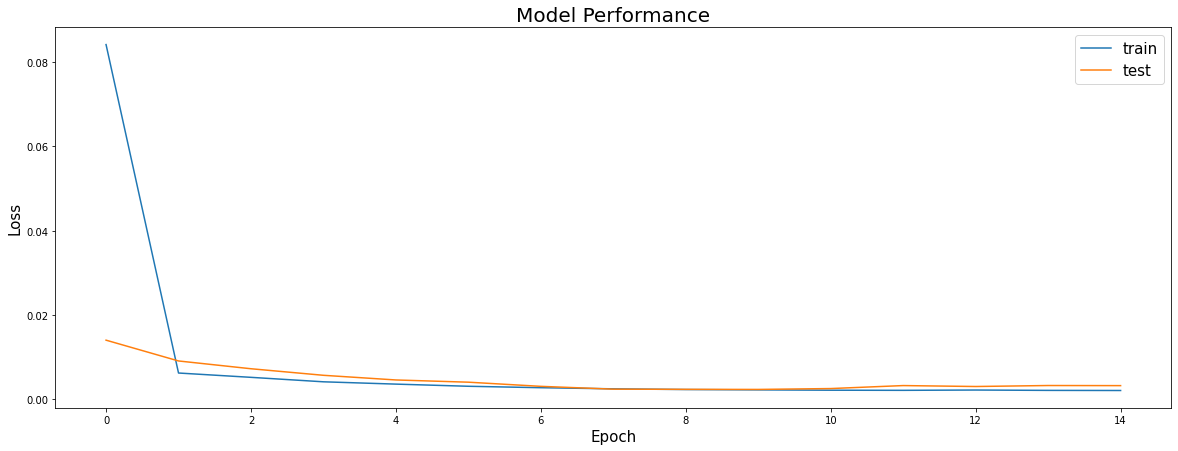

In [23]:
plt.figure(figsize=(20,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend(loc='best', fontsize=15)
plt.xlabel("Epoch",fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.title("Model Performance", fontsize=20)

In [24]:
# Τα μετατρέπουμε στην κανονική τους μορφή και κάνουμε τις προβλέψεις
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(testX.shape[0], 1))
test_actual = scaler_test.inverse_transform(testY.reshape(testX.shape[0], 1))

def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

print(f"Mean Absolute Error: {mean_absolute_error(predicted_btc_price_test_data, test_actual)}")
print(f"Mean Square Error: {mean_squared_error(predicted_btc_price_test_data, test_actual)}")
print(f"r2 score: {r2_score(predicted_btc_price_test_data, test_actual)}")
print(f"Root Mean Square Error: {rmse(predicted_btc_price_test_data, test_actual)}")

Mean Absolute Error: 199.48700588881906
Mean Square Error: 60439.12987369892
r2 score: 0.8429975399940092
Root Mean Square Error: 245.8437102585684


In [25]:
# Τα μετατρέπουμε στην κανονική τους μορφή και κάνουμε τις προβλέψεις
predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(trainX.shape[0], 1))
train_actual = scaler_train.inverse_transform(trainY.reshape(trainY.shape[0], 1))

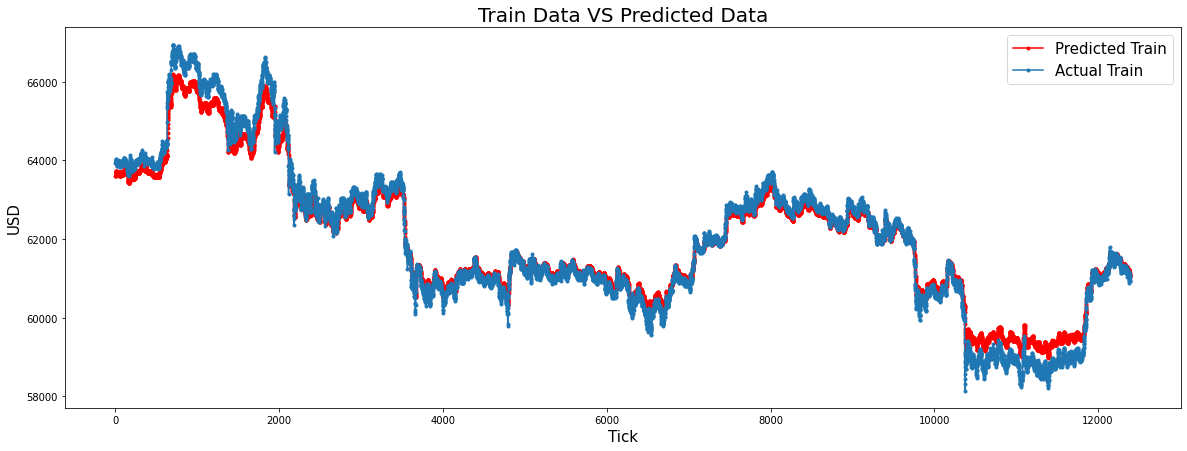

In [26]:
plt.figure(figsize=(20,7))
plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')
plt.plot(train_actual, marker='.', label='Actual Train')
plt.xlabel("Tick", fontsize=15)
plt.ylabel("USD", fontsize=15)
plt.title("Train Data VS Predicted Data", fontsize=20)
plt.legend(loc='best', fontsize='15')

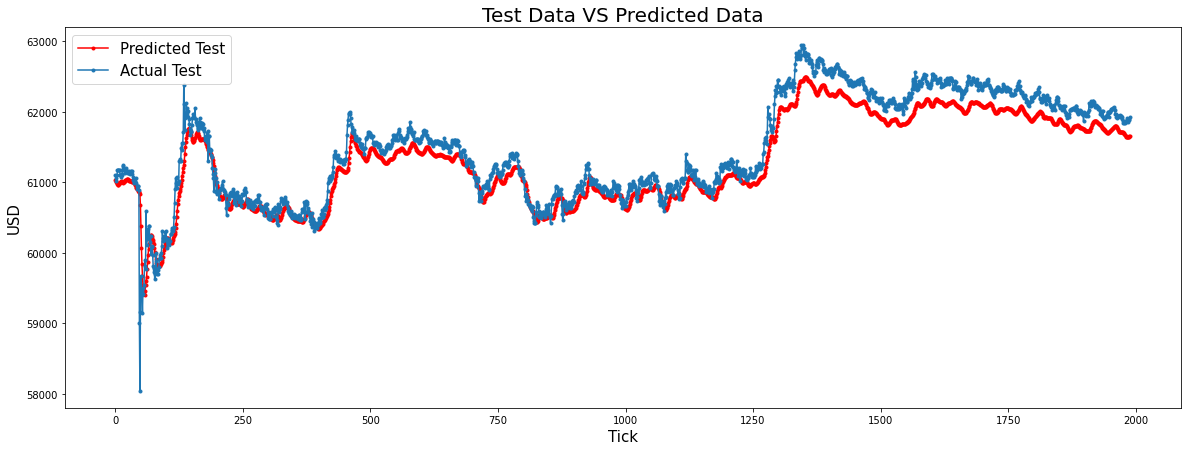

In [27]:
plt.figure(figsize=(20,7))
plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test')
plt.title("Test Data VS Predicted Data", fontsize=20)
plt.xlabel("Tick", fontsize=15)
plt.ylabel("USD", fontsize=15)
plt.legend(loc='best', fontsize='15')

In [28]:
testX.shape

(1990, 10, 1)

## Forecasting

In [29]:
lookback_period = 360 # 6 hours
testX_last_days = testX[testX.shape[0] - lookback_period:]
print(testX_last_days.shape)
predicted_days_forecast_price_test_x = []

for i in range(lookback_period):  
    predicted_forecast_price_test_x = model_from_saved_checkpoint.predict(testX_last_days[i:i+1])
    predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
    predicted_days_forecast_price_test_x.append(predicted_forecast_price_test_x)

predicted_days_forecast_price_test_x = np.array(predicted_days_forecast_price_test_x)
predicted_days_forecast_price_test_x = predicted_days_forecast_price_test_x.flatten()

predicted_btc_price_test_data = predicted_btc_price_test_data.flatten()
predicted_btc_test_concatenated = np.concatenate((predicted_btc_price_test_data, predicted_days_forecast_price_test_x))

(360, 10, 1)


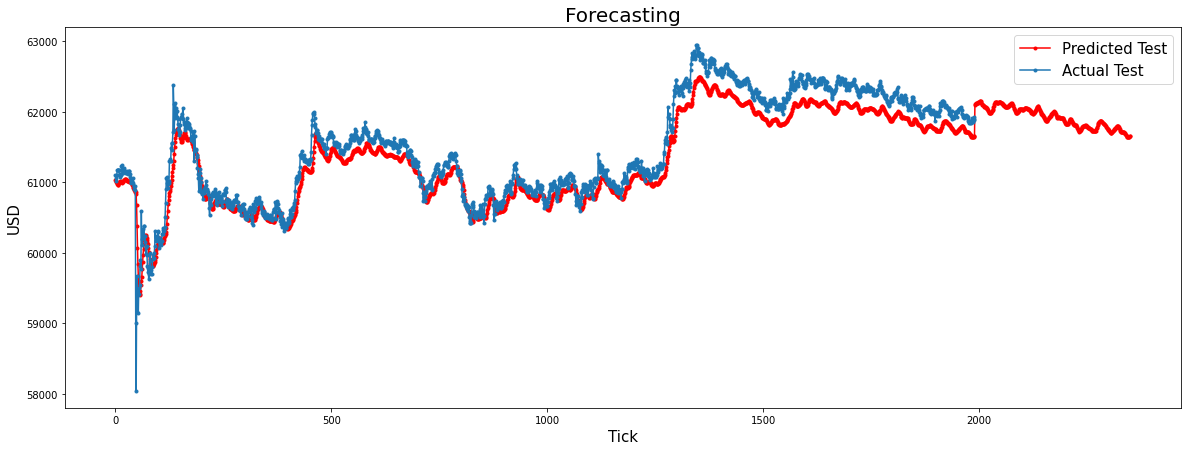

In [30]:
plt.figure(figsize=(20,7))
plt.plot(predicted_btc_test_concatenated, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test')
plt.title("Forecasting", fontsize=20)
plt.xlabel("Tick", fontsize=15)
plt.ylabel("USD", fontsize=15)
plt.legend(loc='best', fontsize='15')

## Create dataframe for our trade positions

In [31]:
df_strategy_actual = pd.DataFrame(test_actual)
df_strategy_predicted = pd.DataFrame(predicted_btc_price_test_data)

df_strategy_actual = df_strategy_actual.rename(columns={0: "close"})
df_strategy_predicted = df_strategy_predicted.rename(columns={0: "close"})

In [32]:
def classify(current, future):
    if future is None:
        return
    """
    Επιστρέφει 1 αν η τιμή στο μέλλον είναι αυξημένη ή
    -1 αν η τιμή στο μέλλον είναι μειωμένη
    """
    if float(future) > float(current):
        return 1
    elif float(future) < float(current):
        return -1

In [33]:
df_strategy_actual['future'] = df_strategy_actual["close"].shift(-1)
df_strategy_predicted['future'] = df_strategy_predicted["close"].shift(-1)
df_strategy_actual['target'] = list(map(classify, df_strategy_actual["close"], df_strategy_actual["future"]))
df_strategy_predicted['target'] = list(map(classify, df_strategy_predicted["close"], df_strategy_predicted["future"]))

frames = [df_strategy_actual, df_strategy_predicted]
result = pd.concat(frames, axis=1, ignore_index=True)
result = result.rename(columns={0: "actual_close", 
                                1:"actual_future_close", 
                                2:"actual_target",
                                3:"predicted_close",
                                4:"predicted_future_close",
                                5:"predicted_target"})
result.dropna(inplace = True)
result["prcnt_change"] = (result['predicted_future_close'] - result['predicted_close'] ) / result['predicted_close']
result.reset_index(inplace=True, drop=True)
result.head(10)

,actual_close,actual_future_close,actual_target,predicted_close,predicted_future_close,predicted_target,prcnt_change
0,61097.72,61058.19,-1.0,61028.777344,61018.847656,-1.0,-0.000163
1,61058.19,61015.05,-1.0,61018.847656,61007.542969,-1.0,-0.000185
2,61015.05,61103.50,1.0,61007.542969,60992.675781,-1.0,-0.000244
3,61103.50,61173.48,1.0,60992.675781,60976.492188,-1.0,-0.000265
4,61173.48,61166.25,-1.0,60976.492188,60965.996094,-1.0,-0.000172
5,61166.25,61178.13,1.0,60965.996094,60965.062500,-1.0,-0.000015
6,61178.13,61168.92,-1.0,60965.062500,60971.894531,1.0,0.000112
7,61168.92,61176.30,1.0,60971.894531,60983.718750,1.0,0.000194
8,61176.30,61102.84,-1.0,60983.718750,60997.238281,1.0,0.000222
9,61102.84,61071.34,-1.0,60997.238281,61008.937500,1.0,0.000192


## RRL Stock Trading

In [34]:
def sharpe_ratio(rets):
    return rets.mean() / rets.std()

def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    Ft = np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
        Ft[t] = np.tanh(np.dot(theta, xt))
    return Ft

def returns(Ft, x, delta=0):
    T = len(x)
    rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
    return np.concatenate([[0], rets])

def gradient(x, theta, delta):
    Ft = positions(x, theta)
    R = returns(Ft, x, delta)
    T = len(x)
    M = len(theta) - 2
    
    A = np.mean(R)
    B = np.mean(np.square(R))
    S = A / np.sqrt(B - A ** 2)

    dSdA = S * (1 + S ** 2) / A
    dSdB = -S ** 3 / 2 / A ** 2
    dAdR = 1. / T
    dBdR = 2. / T * R
    
    grad = np.zeros(M + 2)  
    dFpdtheta = np.zeros(M + 2)  
    
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        dRdF = -delta * np.sign(Ft[t] - Ft[t-1])
        dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
        dSdtheta = (dSdA * dAdR + dSdB * dBdR[t]) * (dRdF * dFdtheta + dRdFp * dFpdtheta)
        grad = grad + dSdtheta
        dFpdtheta = dFdtheta
        
    return grad, S

def train(x, epochs=2000, M=8, commission=0, learning_rate = 0.3):
    theta = np.random.rand(M + 2)
    sharpes = np.zeros(epochs) 
    for i in range(epochs):
        grad, sharpe = gradient(x, theta, commission)
        theta = theta + grad * learning_rate
        sharpes[i] = sharpe
    
    print("finished training")
    return theta, sharpes

In [35]:
rets = btc_input_df['close'].copy().diff()[1:14400]
x = np.array(rets)
N = 12400 
P = 1440
x_train = x[:N]
x_test = x[-P:]

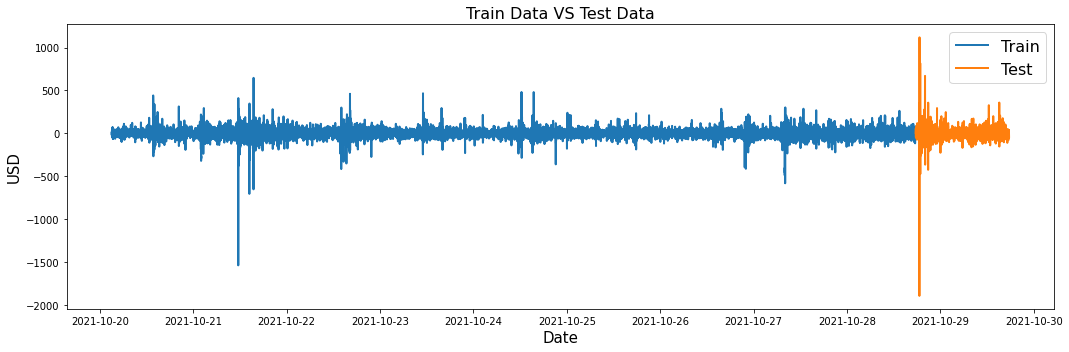

In [36]:
plt.figure(figsize=(15,5))
plt.plot(rets[:N], label='Train', linewidth=2,)
plt.plot(rets[N:N+P], label='Test', linewidth=2,)
plt.ylabel('USD', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.title('Train Data VS Test Data', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.tight_layout()

In [37]:
# standardizing the values
std = np.std(x_train)
mean = np.mean(x_train)

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

# for lstm predictions
x_lstm_test = np.diff(predicted_btc_price_test_data[:1441])
x_lstm_test = (x_lstm_test - mean) / std

In [38]:
%%time
np.random.seed(0)
print('start training')
theta, sharpes = train(x_train, epochs=1000, M=10, commission=0, learning_rate=0.5)

start training
finished training
CPU times: total: 5min 43s
Wall time: 5min 46s


Sharpe ratio: 0.05408894073999378


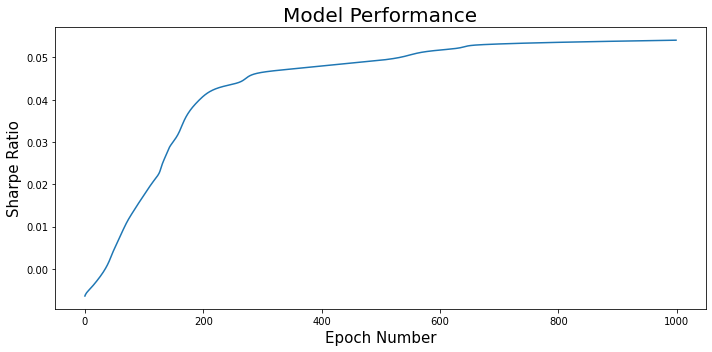

In [39]:
plt.figure(figsize=(10,5))
plt.title("Model Performance", fontsize=20)
plt.plot(sharpes)
plt.xlabel('Epoch Number', fontsize=15)
plt.ylabel('Sharpe Ratio', fontsize=15)
plt.tight_layout()
print(f"Sharpe ratio: {sharpes[-1]}")

In [40]:
train_returns = returns(positions(x_train, theta), x_train)
test_returns = returns(positions(x_test, theta), x_test)

train_positions = positions(x_train, theta)
test_positions = positions(x_test, theta)

lstm_returns= returns(positions(x_lstm_test, theta), x_test)
lstm_positions = positions(x_lstm_test, theta)

RL model on train data: 585.0541623379128 USD
Buy and Hold - train Data: -3.148592497836944e-13 USD
RL model on test data: 62.10885514535365 USD
RL model on lstm predictions: -37.9459163500619 USD
Buy and Hold - test data: 10.32768745933278 USD


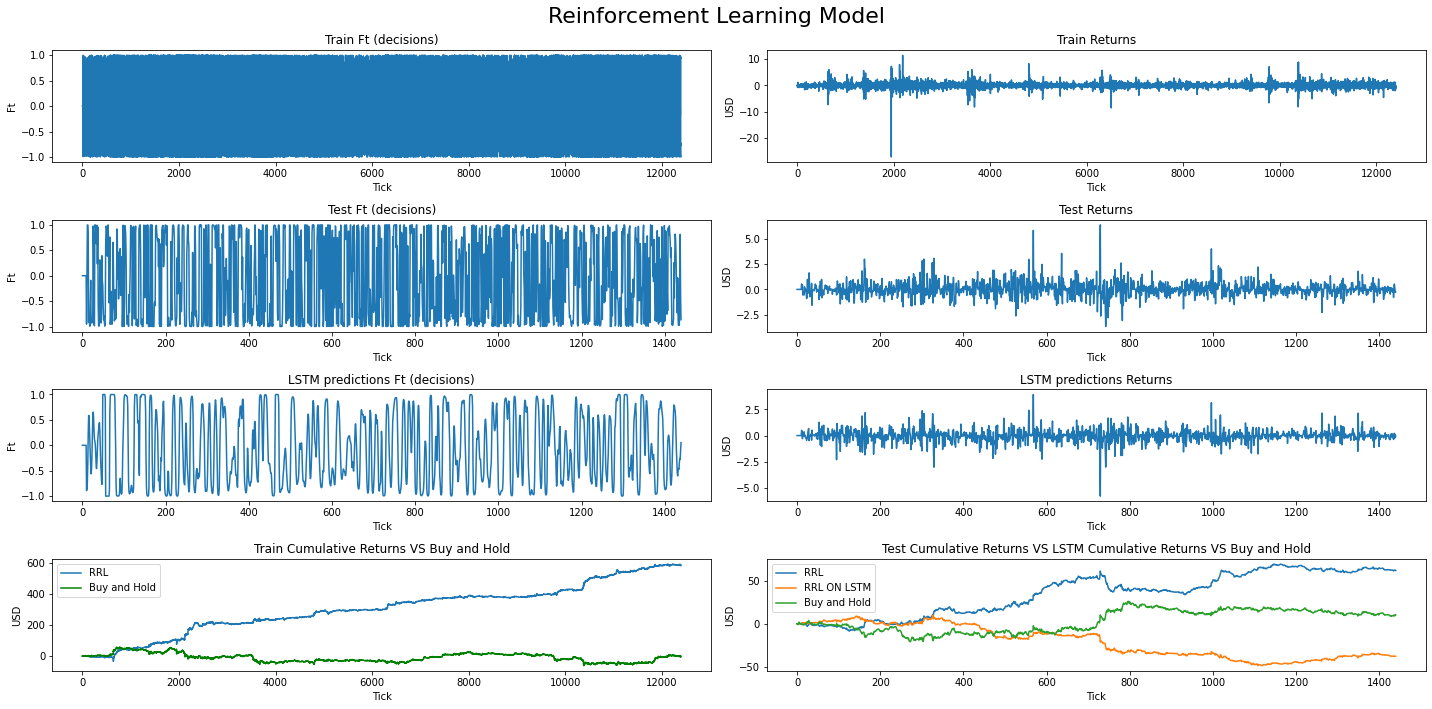

In [41]:
plt.figure(figsize=(20,10))
plt.suptitle('Reinforcement Learning Model', fontsize=22)

plt.subplot(4,2,1)
plt.xlabel("Tick")
plt.ylabel("Ft")
plt.plot(train_positions)
plt.title("Train Ft (decisions)")

plt.subplot(4,2,2)
plt.xlabel("Tick")
plt.ylabel('USD')
plt.plot(train_returns)
plt.title("Train Returns")

plt.subplot(4,2,3)
plt.xlabel("Tick")
plt.ylabel("Ft")
plt.plot(test_positions)
plt.title("Test Ft (decisions)")

plt.subplot(4,2,4)
plt.xlabel("Tick")
plt.ylabel('USD')
plt.plot(test_returns)
plt.title("Test Returns")

plt.subplot(4,2,5)
plt.xlabel("Tick")
plt.ylabel('Ft')
plt.plot(lstm_positions)
plt.title("LSTM predictions Ft (decisions)")

plt.subplot(4,2,6)
plt.xlabel("Tick")
plt.ylabel('USD')
plt.plot(lstm_returns)
plt.title("LSTM predictions Returns")

plt.subplot(4,2,7)
plt.xlabel("Tick")
plt.ylabel('USD')
plt.plot(train_returns.cumsum(), label="RRL")

plt.subplot(4,2,7)
plt.xlabel("Tick")
plt.ylabel('USD')
plt.plot(x_train.cumsum(), color="green", label="Buy and Hold")
plt.title("Train Cumulative Returns VS Buy and Hold")
plt.legend()

plt.subplot(4,2,8)
plt.xlabel("Tick")
plt.ylabel('USD')
plt.plot(test_returns.cumsum(), label= "RRL")
# plt.plot(x_test.cumsum(), label="Buy and Hold", linewidth=1)

plt.subplot(4,2,8)
plt.xlabel("Tick")
plt.plot(lstm_returns.cumsum(), label= "RRL ON LSTM")

plt.subplot(4,2,8)
plt.xlabel("Tick")
plt.plot(x_test.cumsum(), label= "Buy and Hold")
plt.title("Test Cumulative Returns VS LSTM Cumulative Returns VS Buy and Hold")
plt.legend(loc='best')

plt.tight_layout()

print(f"RL model on train data: {train_returns.cumsum()[-1]} USD" )
print(f"Buy and Hold - train Data: {x_train.cumsum()[-1]} USD")
print(f"RL model on test data: {test_returns.cumsum()[-1]} USD")
print(f"RL model on lstm predictions: {lstm_returns.cumsum()[-1]} USD")
print(f"Buy and Hold - test data: {x_test.cumsum()[-1]} USD")

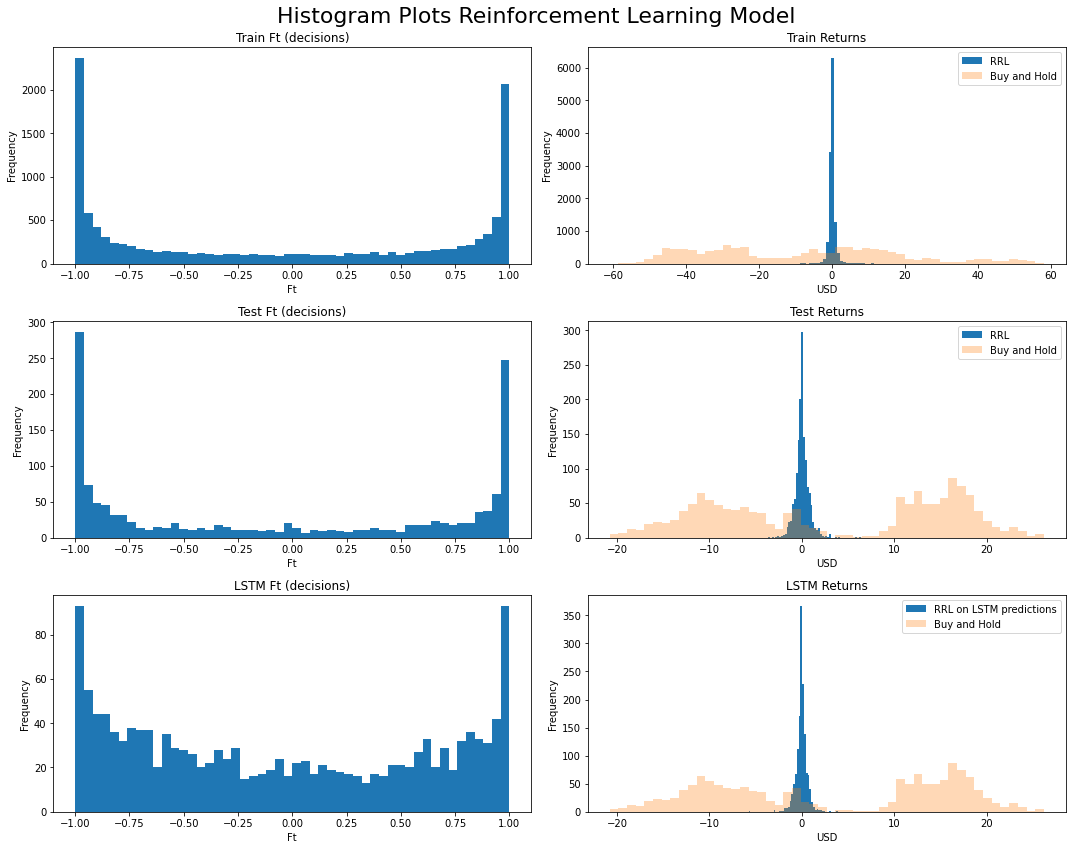

In [42]:
plt.figure(figsize=(15,12))
HIST_BINS = 50
plt.suptitle('Histogram Plots Reinforcement Learning Model', fontsize=22)

plt.subplot(3,2,1)
plt.ylabel("Frequency", )
plt.xlabel("Ft")
plt.hist(train_positions, bins=HIST_BINS)
plt.title("Train Ft (decisions)")

plt.subplot(3,2,2)
plt.ylabel("Frequency", )
plt.xlabel("USD")
plt.hist(train_returns, bins=HIST_BINS, label="RRL")
plt.hist(x_train.cumsum(), bins=HIST_BINS, alpha=0.3, label="Buy and Hold")
plt.title("Train Returns")
plt.legend()

plt.subplot(3,2,3)
plt.xlabel("Ft")
plt.ylabel("Frequency", )
plt.hist(test_positions, bins=HIST_BINS)
plt.title("Test Ft (decisions)")

plt.subplot(3,2,4)
plt.xlabel("USD")
plt.ylabel("Frequency",)
plt.hist(test_returns, bins=HIST_BINS, label="RRL")
plt.hist(x_test.cumsum(), bins=HIST_BINS, alpha=0.3, label="Buy and Hold")
plt.title("Test Returns")
plt.legend()

plt.subplot(3,2,5)
plt.xlabel("Ft")
plt.ylabel("Frequency",)
plt.hist(lstm_positions, bins=HIST_BINS)
plt.title("LSTM Ft (decisions)")

plt.subplot(3,2,6)
plt.ylabel("Frequency", )
plt.xlabel("USD")
plt.hist(lstm_returns, bins=HIST_BINS, label="RRL on LSTM predictions")
plt.hist(x_test.cumsum(), bins=HIST_BINS, alpha=0.3, label="Buy and Hold")
plt.title("LSTM Returns")
plt.legend()

plt.tight_layout()

## Functions for Trading

In [43]:
def trade_long(positions, stock_prices, usd=5000, btc=0, fee=0):
    """
    Αγοράζουμε για όσο προβλέπουμε πως θα ανέβει η τιμή και τα πουλάμε όλα 
    όταν προβλέπουμε πως θα πέσει η τιμή
    """
    cnt = 0
    total = []
    total.append(usd + btc * stock_prices[0])
    print(f"Start with: {total[0]} USD")
    for index in range(len(positions) - 1): 

        # αγοράζουμε
        if positions[index] > 0 and usd > 0:
            buy = positions[index] * usd
            btc = buy / stock_prices[index] + btc
            usd = usd - buy - (fee * buy)
            cnt += 1
            total.append(usd + btc * stock_prices.iloc[index])
            continue

        # πουλάμε 
        if positions[index] < 0 and btc > 0: 
            usd = btc * stock_prices[index] + usd - (fee * btc)
            btc = 0
            cnt += 1
            total.append(usd + btc * stock_prices.iloc[index])
            continue
    
    print(f"End with: {total[-1]} USD\nProfit: {total[-1] - total[0]} USD\n# of trades: {cnt}\n")
    return total

---RRL---
Start with: 5000.0 USD
End with: 5038.903774188739 USD
Profit: 38.90377418873868 USD
# of trades: 900

---RRL ON LSTM---
Start with: 5000.0 USD
End with: 5073.646216249948 USD
Profit: 73.64621624994834 USD
# of trades: 727

---LSTM---
Start with: 5000.0 USD
End with: 5054.371636165446 USD
Profit: 54.371636165446034 USD
# of trades: 1020



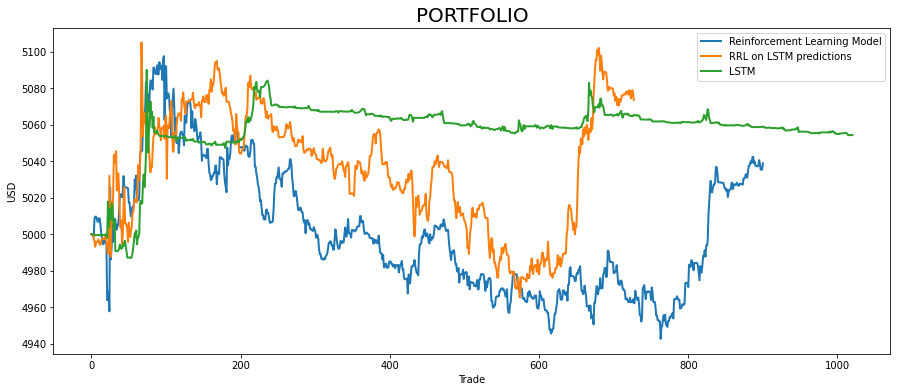

In [44]:
print("---RRL---")
total_rrl = trade_long(positions(x_test[:], theta), result['actual_close'].copy())
print("---RRL ON LSTM---")
total_rrl_lstm = trade_long(positions(x_lstm_test, theta), result['actual_close'].copy())
print("---LSTM---")
total_lstm = trade_long(result['prcnt_change'] * 100, result['actual_close'].copy())

plt.figure(figsize=(15,6))
plt.plot(total_rrl, label="Reinforcement Learning Model", linewidth=2)
plt.plot(total_rrl_lstm, label="RRL on LSTM predictions", linewidth=2)
plt.plot(total_lstm, label="LSTM", linewidth=2)
plt.xlabel('Trade')
plt.ylabel('USD')
plt.legend()
plt.title("PORTFOLIO", fontsize=20)

In [45]:
def trade_short(positions, stock_prices, usd=0, btc=2, fee=0):
    """
    Στην συγκεκριμένη στρατηγική πουλάμε όλα τα bitcoin που έχουμε,
    και αγοράζουμε την ίδια ποσότητα που πουλήσαμε όταν προβλέπουμε πως θα ξαναανέβει η τιμή
    """
    cnt = 0
    total = []
    total.append(usd + btc * stock_prices[0])
    short = False
    first_btc = copy.deepcopy(btc)
    print(f"Start with: {total[0]} USD")
    for index in range(len(positions) - 1): 
        # αγοράζουμε
        if positions[index] > 0  and usd > 0 and usd >= (first_btc) * stock_prices[index]:
            buy = copy.deepcopy(first_btc)
            btc = buy / stock_prices[index] + btc
            usd = usd - buy - (fee * buy)
            cnt += 1
            total.append(usd + btc * stock_prices.iloc[index])
            short = False
            continue

        # πουλάμε 
        if positions[index] < 0 and btc > first_btc - (first_btc / 2):  
            first_btc = copy.deepcopy(btc)
            usd = btc * stock_prices[index] + usd - (fee * btc)
            btc = 0
            cnt += 1
            total.append(usd + btc * stock_prices.iloc[index])
            short = True
            continue
        
    print(f"End with: {total[-1]} USD\nProfit: {total[-1] - total[0]} USD\n# of trades: {cnt}\n")
    
    return total

---RRL---
Start with: 122195.44 USD
End with: 122144.28773346226 USD
Profit: -51.152266537741525 USD
# of trades: 221

---RRL ON LSTM---
Start with: 122195.44 USD
End with: 122144.50443798608 USD
Profit: -50.93556201392494 USD
# of trades: 210

---LSTM---
Start with: 122195.44 USD
End with: 122197.07399095948 USD
Profit: 1.6339909594826167 USD
# of trades: 214



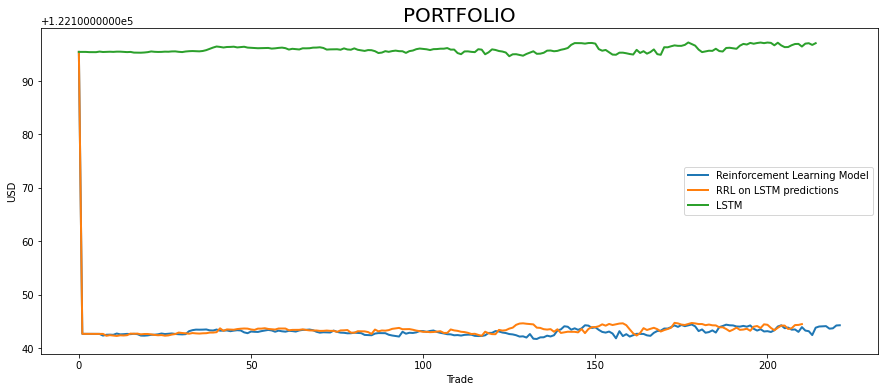

In [46]:
print("---RRL---")
total_rrl = trade_short(positions(x_test[:], theta), result['actual_close'].copy())
print("---RRL ON LSTM---")
total_rrl_lstm = trade_short(positions(x_lstm_test, theta), result['actual_close'].copy())
print("---LSTM---")
total_lstm = trade_short(result['prcnt_change'], result['actual_close'].copy())

plt.figure(figsize=(15,6))
plt.plot(total_rrl, label="Reinforcement Learning Model", linewidth=2)
plt.plot(total_rrl_lstm, label="RRL on LSTM predictions", linewidth=2)
plt.plot(total_lstm, label="LSTM", linewidth=2)
plt.xlabel('Trade')
plt.ylabel('USD')
plt.legend(loc='best')
plt.title("PORTFOLIO", fontsize=20)